In [0]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression


In [0]:


# Initialize the Spark session
spark = SparkSession.builder \
    .appName("California Housing Regression") \
    .getOrCreate()


In [0]:
from pyspark.ml.feature import VectorAssembler
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Fetch the dataset using sklearn
cal_housing = fetch_california_housing()
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
df['target'] = cal_housing.target

# Convert the Pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)

# Display the DataFrame
spark_df.show()

+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|target|
+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23| 4.526|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22| 3.585|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24| 3.521|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25| 3.413|
|3.8462|    52.0| 6.281853281853282|1.0810810810810811|     565.0|2.1814671814671813|   37.85|  -122.25| 3.422|
|4.0368|    52.0| 4.761658031088083|1.1036269430051813|     413.0| 2.139896373056995|   37.85|  -122.25|

In [0]:
from pyspark.sql.functions import col, count, isnan, when

# Checking for missing values in each column
missing_data = spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns])
missing_data.show()

+------+--------+--------+---------+----------+--------+--------+---------+------+
|MedInc|HouseAge|AveRooms|AveBedrms|Population|AveOccup|Latitude|Longitude|target|
+------+--------+--------+---------+----------+--------+--------+---------+------+
|     0|       0|       0|        0|         0|       0|       0|        0|     0|
+------+--------+--------+---------+----------+--------+--------+---------+------+



In [0]:
# outliers handling- Ceiling & Flooring based on statistical ourliers we want to exclude
quantiles = spark_df.approxQuantile("target", [0.01, 0.99], 0.05)
lower_bound = quantiles[0]
upper_bound = quantiles[1]

In [0]:
# Handling missing values - Assuming you replace them with the median (can vary based on specific needs) but 
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=spark_df.columns, outputCols=["{}_imputed".format(c) for c in spark_df.columns])
spark_df2 = imputer.fit(spark_df).transform(spark_df)

In [0]:
spark_df3 = spark_df2.withColumn("target", when(col("target") < lower_bound, lower_bound).otherwise(col("target")))
spark_df4 = spark_df3.withColumn("target", when(col("target") > upper_bound, upper_bound).otherwise(col("target")))

In [0]:
# Use VectorAssembler to combine feature columns into a single vector column
feature_cols = cal_housing.feature_names
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")




In [0]:


# After cleaning, assemble features again (if features were also cleaned/adjusted)
feature_vector_df = assembler.transform(spark_df4)
finalized_data = feature_vector_df.select("features", "target")


In [0]:
# Split the data into train and test sets
training_data, testing_data, validation_data = finalized_data.randomSplit([0.7, 0.1, 0.2], seed=42)


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions
predictions = lr_model.transform(testing_data)

# Select example rows to display
predictions.select("prediction", "target").show(20)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


+-------------------+------+
|         prediction|target|
+-------------------+------+
| 0.5153854868714589| 0.895|
|  1.325731235058221| 1.625|
| 1.0655106094460436| 1.625|
| 0.9447173898466303| 1.125|
| 1.5300576856843975| 1.375|
|0.07445099359780016| 0.425|
| 1.1567744620027938|   1.5|
|0.28960376418719136|  0.25|
| 0.6928716062179276| 0.494|
|   0.93231719348708| 1.542|
| 1.4942932040722994| 0.861|
| 1.3055836453326606| 1.719|
| 0.7107982522184599| 0.504|
|  1.619651596010364| 1.188|
| 0.3545703548126511|   0.4|
|  1.039022510529648| 0.875|
| 1.2917567984118037| 0.691|
| 1.3887152144838169| 1.045|
| 0.7751125049811165|  0.75|
| 1.3897164597972207| 0.871|
+-------------------+------+
only showing top 20 rows

Root Mean Squared Error (RMSE) on test data = 0.7184313638385542


In [0]:
# Make predictions
predictions_val = lr_model.transform(validation_data)

# Select example rows to display
predictions_val.select("prediction", "target").show(20)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")
rmse_val = evaluator.evaluate(predictions_val)
print(f"Root Mean Squared Error (RMSE) on VAlidation data = {rmse}")

+--------------------+-------+
|          prediction| target|
+--------------------+-------+
|  0.9894668651052072|5.00001|
|  0.7266683998090144|   3.75|
|  1.5307645065690778|    3.5|
|  1.0660022306203416|  1.688|
|   1.001895192351732|  0.818|
|  1.2580544309165376|  0.844|
|   0.952654504462906|  1.813|
|  1.2123720236816737|  0.842|
|    1.49454600676696|  0.955|
|  1.5562256878651297|  1.875|
|  1.1900313000959244|  1.775|
|  1.1305010591799984|  1.516|
|0.013279450316780128|  0.889|
|  1.4153055035188373|  1.875|
|  1.1430915767959107|  1.058|
|  1.0205943266601238|   0.48|
|  0.9366967450388941|  1.354|
|  0.7201757785102743|  0.467|
|  0.9412852014624704|  0.875|
|  1.2121295769808214|  0.982|
+--------------------+-------+
only showing top 20 rows

Root Mean Squared Error (RMSE) on VAlidation data = 0.7184313638385542


In [0]:

from pyspark.ml.regression import LinearRegression

# Using Linear Regression for a regression task
k_regression = LinearRegression(featuresCol='features', labelCol='target')

In [0]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='target')

# Train the model
lr_model = lr.fit(training_data)


In [0]:
paramGrid = ParamGridBuilder() \
    .addGrid(k_regression.regParam, [0.1, 0.01]) \
    .addGrid(k_regression.maxIter, [10, 20]) \
    .build()


from pyspark.ml.evaluation import RegressionEvaluator

kevaluator = RegressionEvaluator(predictionCol='prediction', labelCol='target', metricName="rmse")  # Using RMSE as the metric

crossval = CrossValidator(estimator=k_regression,
                          estimatorParamMaps=paramGrid,
                          evaluator=kevaluator,
                          numFolds=5)  # Use 5-fold CrossValidator


In [0]:
cvModel = crossval.fit(finalized_data)


In [0]:
print("Best model's metrics:", cvModel.avgMetrics)


Best model's metrics: [0.7560132677222826, 0.7560132677223119, 0.729575647628816, 0.7295756476288212]


In [0]:
# Collect the data into a Pandas DataFrame for easier plotting
import pandas as pd
import matplotlib.pyplot as plt

predictions_dataframe = predictions.select("prediction", "target").toPandas()



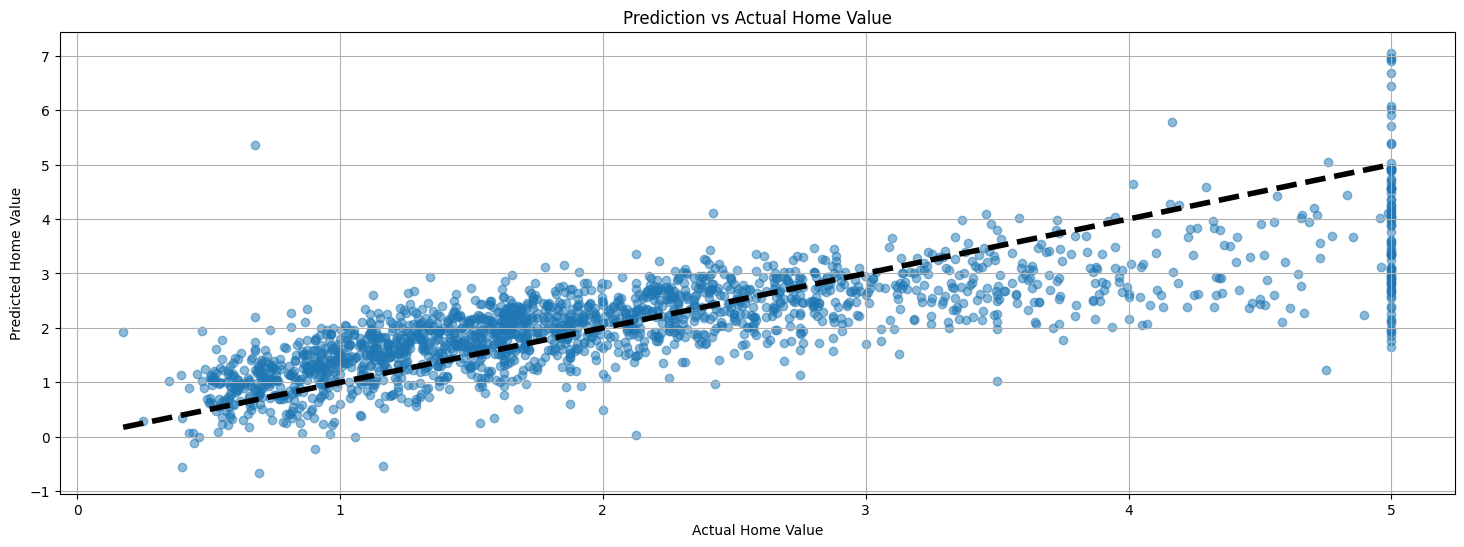

In [0]:
# Mapping a plot with line of fit for perfect predictions
plt.figure(figsize=(18, 6))
plt.scatter(predictions_dataframe['target'], predictions_dataframe['prediction'], alpha=0.5)
plt.plot([predictions_dataframe['target'].min(), predictions_dataframe['target'].max()], 
         [predictions_dataframe['target'].min(), predictions_dataframe['target'].max()], 
         'k--', lw=4)
plt.title('Prediction vs Actual Home Value')
plt.xlabel('Actual Home Value')
plt.ylabel('Predicted Home Value')
plt.grid(True)
plt.show()


In [0]:
# Stop the Spark session
spark.stop()
